In [75]:
import numpy as np
import qiskit as qk
from qiskit.circuit.library import TwoLocal
import qutip as qt
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.optimize as OPT
from IPython.display import display


In [76]:
backend = qk.Aer.get_backend('qasm_simulator')
num_shots=1000

In [77]:
def create_UCC_ansatz(qr,cr):
    """Create circuit with the UCC Ansatz using THETA which 
       is a Parameter variable defined in qiskit
    """
    # Create registers
    circ = qk.QuantumCircuit(qr, cr)
    THETA=qk.circuit.Parameter('θ')
    # Apply ansatz
    #######################
    circ.x(0)
    circ.barrier(range(2))
    circ.rx(-3.14159/2,0)
    circ.ry(3.14159/2,1)
    circ.cx(0,1)
    circ.rz(2*THETA, 1)
    circ.cx(0,1)
    circ.rx(3.14159/2,0)
    circ.ry(-3.14159/2,1)
    
    
    #######################
    
    return circ

UCC Ansatz


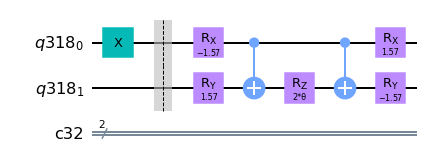

In [78]:
qr = qk.QuantumRegister(2)
cr = qk.ClassicalRegister(2)
circ1=create_UCC_ansatz(qr,cr)
# check that the circuit is drawn correctly
print('UCC Ansatz')
display(circ1.draw('mpl'))

In [81]:
def measurement_circuits(circ):
    '''
    Takes as input a circuit and
    returns a list of circuits that measures along x, y and z
    '''
    circ_x=circ.copy()
    circ_x.name=circ_x.name+'-x'
    circ_x.h(range(circ.num_qubits))
    circ_x.measure_all(inplace=True)    

    circ_y=circ.copy()
    circ_y.name=circ_y.name+'-y'
    circ_y.sdg(range(circ.num_qubits))
    circ_y.h(range(circ.num_qubits))
    circ_y.measure_all()

    circ_z=circ.copy()
    circ_z.name=circ_z.name+'-z'
    circ_z.measure_all()

    return [circ_x,circ_y,circ_z]

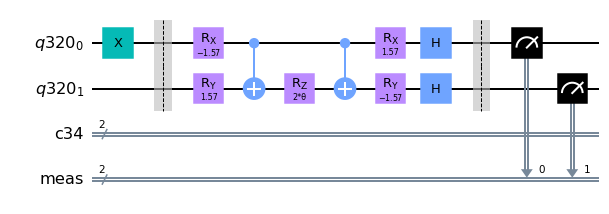

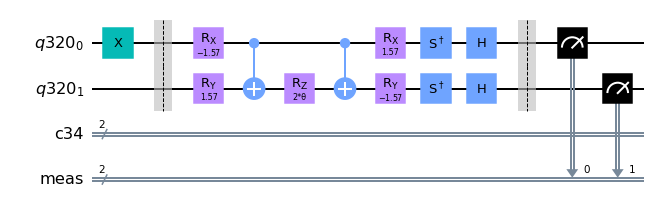

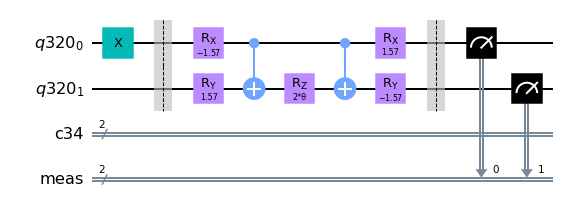

In [82]:
# Checking to see whether the measurement circuits are correct

qr = qk.QuantumRegister(2)
cr = qk.ClassicalRegister(2)
circ1 = create_UCC_ansatz(qr,cr)
[circ_x,circ_y,circ_z] = measurement_circuits(circ1)

display(circ_x.draw('mpl'))
display(circ_y.draw('mpl'))
display(circ_z.draw('mpl'))

In [83]:
def calculate_probabilities_after_measurement(circ):
    '''
    Takes in a circuit (non parameterized) executes it with measurements along x, y and z,
    and returns the measurement outcome probabilities of the bitstrings in that basis
    '''
    circ_measured=measurement_circuits(circ)
    job = qk.execute(circ_measured, backend=backend,shots=num_shots)
    result = job.result()
    result_counts_x=result.get_counts(circ_measured[0].name)
    result_counts_y=result.get_counts(circ_measured[1].name)
    result_counts_z=result.get_counts(circ_measured[2].name)
    px_dict= {key:result_counts_x[key]/num_shots for key in result_counts_x}
    py_dict= {key:result_counts_y[key]/num_shots for key in result_counts_y} 
    pz_dict= {key:result_counts_z[key]/num_shots for key in result_counts_z}
    return [px_dict,py_dict,pz_dict]

In [84]:
def calculate_expectation_value(circ_bound,g_vals):
    '''
    Takes in a circuit (circ_bound) with a value bound to the parameter, 
    performs measurements and returns the expectation value.
    It should calculate the expectation value using the dictionary g_vals, that has the parameters
    gvals={'g0':,'g1':,'g2':,'g3':,'g4':, 'g5':}
    '''
    
    px,py,pz=calculate_probabilities_after_measurement(circ_bound) 
    
    H_expectval= (g_vals['g0']+
                  g_vals['g1']* (pz.get('00', 0) - pz.get('01', 0)+ pz.get('10', 0) - pz.get('11', 0))+
                  g_vals['g2']* (pz.get('00', 0) + pz.get('01', 0)-pz.get('10', 0) - pz.get('11', 0))+
                  g_vals['g3']* (pz.get('00', 0) - pz.get('01', 0)- pz.get('10', 0) + pz.get('11', 0))+  
                  g_vals['g4']* (py.get('00', 0) - py.get('01', 0)-py.get('10', 0) + py.get('11', 0))+
                  g_vals['g5']* (px.get('00', 0) - px.get('01', 0)- px.get('10', 0) + px.get('11', 0)))
    return H_expectval

In [85]:
import shutil
import os

# Get the current directory
current_dir = os.getcwd()

# Specify the directory where the CSV file is located
csv_dir = 'C:\\Users\\celia\\Downloads\\'

# Specify the file name
file_name = 'g_values.csv'

# Copy the file to the current directory
shutil.copy(os.path.join(csv_dir, file_name), current_dir)

'C:\\Users\\celia\\g_values.csv'

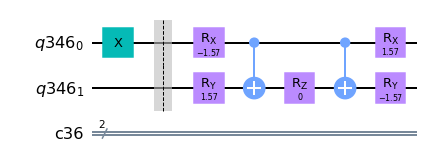

Expected value of energy of H2 molecule for R=0.20Å and θ=0.00 rads is 2.85 Hartree


In [87]:
# Compute for the first row of parameters, for THETA=0 in the UCC Ansatz (corresponds to R=0.2)
p=0
gvals={'g0':H2_data['g0'][p],
       'g1':H2_data['g1'][p],
       'g2':H2_data['g2'][p],
       'g3':H2_data['g3'][p],
       'g4':H2_data['g4'][p],
       'g5':H2_data['g5'][p],
        }

theta_val=0

qr = qk.QuantumRegister(2)
cr = qk.ClassicalRegister(2)
circ=create_UCC_ansatz(qr,cr)
circ_bound=circ.bind_parameters({circ.parameters[0]:theta_val}) # binds the value theta_val to the parameter in the circuit
display(circ_bound.draw('mpl'))
H_val=calculate_expectation_value(circ_bound,gvals)
print('Expected value of energy of H2 molecule for R=%.2fÅ and θ=%.2f rads is %.2f Hartree'%(H2_data['R'][p],theta_val,H_val))

In [88]:
# Extract parameters from the provided table taken from the paper
data=np.genfromtxt('g_values.csv',delimiter=',')
H2_data={'R':data[1:,0],
         'g0':data[1:,1],
         'g1':data[1:,2],
         'g2':data[1:,3],
         'g3':data[1:,4],
         'g4':data[1:,6],
         'g5':data[1:,5],
        }
p=10
print("""For example, for bond distance, R=%.2f, 
we have the parameters:(g0,g1,g2,g3,g4,g5):(%.2f,%.2f,%.2f,%.2f,%.2f,%.2f)
      """%(H2_data['R'][p],
             H2_data['g0'][p],
             H2_data['g1'][p],
             H2_data['g2'][p],
             H2_data['g3'][p],
             H2_data['g4'][p],
             H2_data['g5'][p],
          )
     )

For example, for bond distance, R=0.70, 
we have the parameters:(g0,g1,g2,g3,g4,g5):(0.30,0.36,-0.48,0.58,0.09,0.09)
      


In [89]:
def exhaustive_search(circ_parametrized,gvals,theta_lb,theta_ub):
    '''
    Exhaustively searches over 100 different values of parameters between theta_lb and theta_ub to
    find optimal value of θ.
    Takes as input a parameterized circuit, bind a value of theta to it and calculate the expectation value.
    '''
    phi = 0
    theta_vals=np.linspace(theta_lb,theta_ub,100) # 100 different angles between θmin and θmax
    H_vals=[]
    
    for theta in theta_vals:
        circ_inst = circ_parametrized.bind_parameters({phi: theta})
        expectation_value = calculate_expectation_value(circ_inst, gvals)
        H_vals.append(expectation_value)
    H_vals = np.array(H_vals)
    theta_min = theta_vals[np.argmin(H_vals)]
    H_min = np.min(H_vals)
    
    return theta_min,H_min

In [90]:
#conditions on parameters
p=20
gvals={'g0':H2_data['g0'][p],
       'g1':H2_data['g1'][p],
       'g2':H2_data['g2'][p],
       'g3':H2_data['g3'][p],
       'g4':H2_data['g4'][p],
       'g5':H2_data['g5'][p],
        }

#define variational circuit
qr = qk.QuantumRegister(2)
cr = qk.ClassicalRegister(2)
circ=create_UCC_ansatz(qr,cr)

theta_min,H_min=exhaustive_search(circ,gvals,0,np.pi)
print(' Expected value of energy of H2 molecule for R=%.2fÅ  is minimum (using exhaustive search) at and θ=%.2f rads and is %.3f Hartree'%(H2_data['R'][p],theta_min,H_min))

QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([Parameter(θ)]), ParameterView([Parameter(θ)]), ParameterView([Parameter(θ)])]'